In [31]:
# import one function graph to nx and plot it
import networkx as nx
import json
import matplotlib.pyplot as plt

folder ='./plugin/newprogram_2019-04-03_21-25-24/'
filename = 'sub_451000_edges.txt'
filename = 'WINHTTP_452F00_edges.txt'


# read nodes, edges and  edge attributes
g = nx.read_edgelist(folder+filename)
# read node attributes
with open(folder+filename.replace('edges','nodes'),'r') as f:
    for line in f.readlines():
        tokens = line.split("{")
        nodeid = tokens[0][:-1]
        #print(nodeid)
        #print(tokens[1])
        attr_dict = json.loads('{ '+tokens[1].replace('\'','"'))
        #print(nodeid)
        #print(attr_dict)
        for k,v in attr_dict.items():
            g.node[nodeid][k] = v

In [32]:
i=0
for n1, n2, attr in g.edges(data=True): # unpacking
    print(n1, n2, attr) 
    i+=1
    if i>3: break


4534016 0 {'type': 'data'}
4534016 4534017 {'type': 'func'}
0 4534017 {'type': 'data'}
0 4534019 {'type': 'data'}


In [33]:
i=0
for n in g.nodes(data=True):
    print(n)
    i+=1
    if i>3: break

('4534016', {'type': 'instr', 'content': 'push'})
('0', {})
('4534017', {'type': 'instr', 'content': 'mov'})
('4534019', {'type': 'instr', 'content': 'push'})


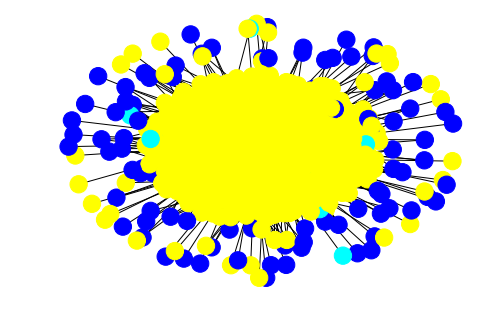

In [34]:
# color plot
attrs={}
palette = ['yellow', 'cyan','orange','red','magenta', 'silver','grey','blue','green',   'pink','black',]
types =['instr','func','data','immediate','memory','displacement']

for node in g.nodes():
    if 'type' in g.node[node].keys():
        i = types.index(g.node[node]['type'])
    else:
        i=len(types)+1
    attrs[node]={'color':palette[ i % len(palette)]}

nx.set_node_attributes(g, attrs)
colors = nx.get_node_attributes(g, 'color')
nx.draw(g, node_color=colors.values())
plt.draw()

In [50]:
import networkx as nx
import json
import matplotlib.pyplot as plt


def plotGraphFunction(filename, folder):
    
    # read nodes, edges and  edge attributes
    g = nx.read_edgelist(folder+filename)
    # read node attributes
    with open(folder+filename.replace('edges','nodes'),'r') as f:
        for line in f.readlines():
            tokens = line.split("{")
            nodeid = tokens[0][:-1]
            #print(nodeid)
            #print(tokens[1])
            attr_dict = json.loads('{ '+tokens[1].replace('\'','"'))
            #print(nodeid)
            #print(attr_dict)
            for k,v in attr_dict.items():
                g.node[nodeid][k] = v

    # color plot
    attrs={}
    palette = ['yellow', 'cyan','orange','red','magenta', 'silver','grey','blue','green',   'pink','black',]
    types =['instr','func','data','immediate','memory','displacement']

    for node in g.nodes():
        if 'type' in g.node[node].keys():
            i = types.index(g.node[node]['type'])
        else:
            i=0
        attrs[node]={'color':palette[ i % len(palette)]}

    nx.set_node_attributes(g, attrs)
    colors = nx.get_node_attributes(g, 'color')
    nx.draw(g, node_color=colors.values())
    #nx.draw_circular(g, node_color=colors.values())
    plt.draw()
    

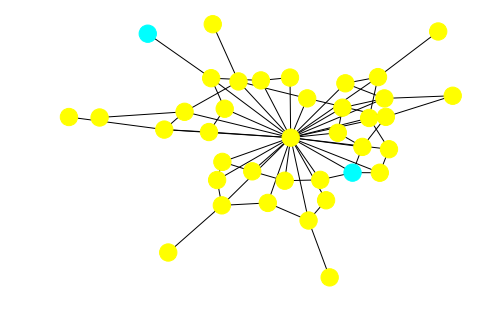

In [51]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-03_21-25-24/',
                  filename = 'sub_451000_edges.txt')


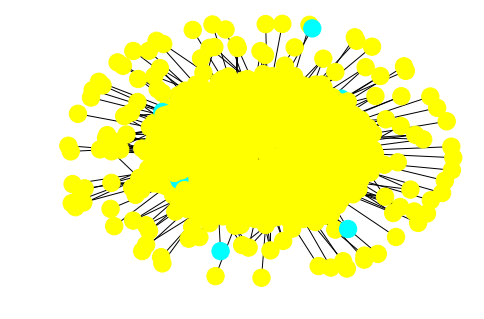

In [52]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-03_21-25-24/',
                  filename = 'WINHTTP_452F00_edges.txt')

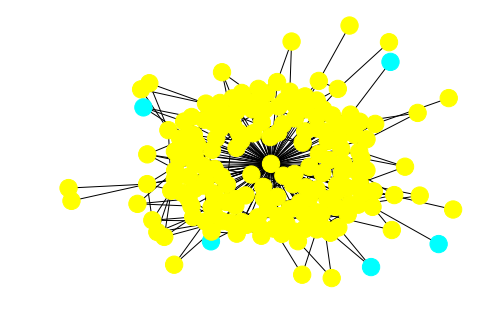

In [53]:
plotGraphFunction(folder ='./plugin/newprogram_2019-04-03_21-25-24/',
                  filename = 'sub_45F370_edges.txt')